##3 classes: classical, jazz, rock

###Network: 
5 conv+max pooling, 2 dense 



In [ ]:
#importing google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#setting the working directory
%cd /gdrive/MyDrive/Colab Notebooks/NAML/Project

/gdrive/MyDrive/Colab Notebooks/NAML/Project


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import librosa
import os

tfk = tf.keras
tfkl = tf.keras.layers
seed = 42

In [ ]:
dataset = []
# genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

genres = { 'classical': 0, 'jazz': 1, 'rock': 2}

n_genres = 3

for genre, genre_number in genres.items():
    for filename in os.listdir(f'dataset_old/genres/{genre}'):
        songname = f'dataset_old/genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=29.7)
        ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512)
        ps = librosa.power_to_db(ps**2)
        dataset.append( (ps, genre_number) )
    print(str(genre+' done'))

classical done
jazz done
rock done


In [ ]:
order = np.arange(start = 0, stop = 100, step = 1)

np.random.seed(42)

training = []
validation = []
test = []

for i in range(3):
  shuffle = np.random.permutation(order)
  for k in range(70):
    training.append(dataset[i*100 + shuffle[k]])
  for l in range(20):
    validation.append(dataset[i*100 + shuffle[l+70]])
  for m in range(10):
    test.append(dataset[i*100 + shuffle[m+90]])

In [ ]:
X_train, Y_train = zip(*training)
X_valid, Y_valid = zip(*validation)
X_test, Y_test = zip(*test)

X_train = np.array([x.reshape( (128, 2559, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 2559, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 2559, 1) ) for x in X_test])

Y_train = np.array(tfk.utils.to_categorical(Y_train, n_genres))
Y_valid = np.array(tfk.utils.to_categorical(Y_valid, n_genres))
Y_test = np.array(tfk.utils.to_categorical(Y_test, n_genres))

### 6 conv e double conv + max pool + GAP final, square filters

In [ ]:
def build_model(input_shape, n_units):
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=4,
        kernel_size=(5, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1_2 = tfkl.Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1_2)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2_2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2_2)

    conv3 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4_2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4_2)

    conv5 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    conv6 = tfkl.Conv2D(
        filters=286,
        kernel_size=(1,1),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool5)
    

    global_average = tfkl.GlobalAveragePooling2D(name = 'GAP')(conv6)
    global_average = tfkl.Dropout(0.3, seed=seed)(global_average)
    
    classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(global_average)
    #flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    #flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)
    #classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(flattening_layer)
    
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    classifier_layer_2 = tfkl.Dense(units=32, name='Classifier_2', activation='relu')(classifier_layer)
    classifier_layer_2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer_2)
    output_layer = tfkl.Dense(units=n_units, activation='softmax', name='Output')(classifier_layer_2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model

    return model

In [ ]:

input_shape = (128, 2559, 1)

model = build_model(input_shape, n_genres)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 2559, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2559, 4)      104       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 2559, 8)      296       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1279, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 1279, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 1279, 16)      2320      
                                                             

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
adaptive_LR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)

standard_history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = 500,
    batch_size = 64,
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping, adaptive_LR]
    )

Epoch 1/500
4/4 [==============================] - 25s 2s/step - loss: 1.1568 - accuracy: 0.3000 - val_loss: 1.0979 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 3s 793ms/step - loss: 1.1032 - accuracy: 0.3095 - val_loss: 1.0979 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 3s 787ms/step - loss: 1.1018 - accuracy: 0.3333 - val_loss: 1.0976 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 3s 792ms/step - loss: 1.0998 - accuracy: 0.3238 - val_loss: 1.0968 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 3s 787ms/step - loss: 1.0976 - accuracy: 0.3571 - val_loss: 1.0969 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 3s 788ms/step - loss: 1.0970 - accuracy: 0.3333 - val_loss: 1.0963 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 3s 792ms/step - loss: 1.097

Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1: 0.9


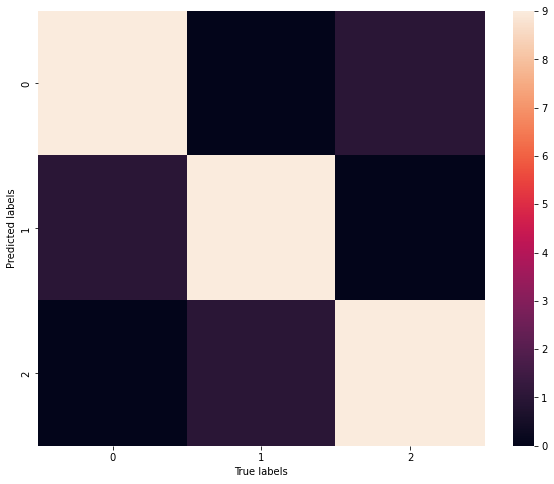

In [ ]:
predictions = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### As before but rectangular filters

In [ ]:
def build_model_1(input_shape, n_units):
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=4,
        kernel_size=(3, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1_2 = tfkl.Conv2D(
        filters=8,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1_2)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2_2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2_2)

    conv3 = tfkl.Conv2D(
        filters=32,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4_2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4_2)

    conv5 = tfkl.Conv2D(
        filters=128,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    conv6 = tfkl.Conv2D(
        filters=286,
        kernel_size=(1,2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool5)
    

    global_average = tfkl.GlobalAveragePooling2D(name = 'GAP')(conv6)
    global_average = tfkl.Dropout(0.3, seed=seed)(global_average)
    
    classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(global_average)
    #flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    #flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)
    #classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(flattening_layer)
    
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    classifier_layer_2 = tfkl.Dense(units=32, name='Classifier_2', activation='relu')(classifier_layer)
    classifier_layer_2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer_2)
    output_layer = tfkl.Dense(units=n_units, activation='softmax', name='Output')(classifier_layer_2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model

    return model

In [ ]:
input_shape = (128, 2559, 1)

model_1 = build_model_1(input_shape, n_genres)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 2559, 1)]    0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 2559, 4)      64        
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 2559, 8)      200       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 1279, 8)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 1279, 16)      784       
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 1279, 16)      1552      
                                                             

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
adaptive_LR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)

standard_history_1 = model_1.fit(
    x = X_train,
    y = Y_train,
    epochs = 500,
    batch_size = 64,
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping, adaptive_LR]
    )

Epoch 1/500
4/4 [==============================] - 11s 2s/step - loss: 1.1695 - accuracy: 0.3667 - val_loss: 1.0901 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 3s 742ms/step - loss: 1.0979 - accuracy: 0.3476 - val_loss: 1.0906 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 3s 744ms/step - loss: 1.1021 - accuracy: 0.3714 - val_loss: 1.0847 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 3s 745ms/step - loss: 1.0941 - accuracy: 0.3714 - val_loss: 1.0782 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 3s 743ms/step - loss: 1.0803 - accuracy: 0.4476 - val_loss: 1.0702 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 3s 746ms/step - loss: 1.0497 - accuracy: 0.4381 - val_loss: 1.0117 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 3s 743ms/step - loss: 1.001

Accuracy: 0.9333
Precision: 0.9444
Recall: 0.9333
F1: 0.9346


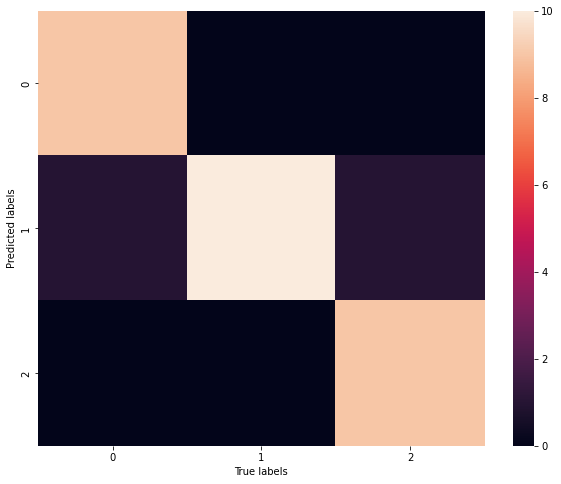

In [ ]:
predictions_1 = model_1.predict(X_test)

# Compute the confusion matrix
cm_1= confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions_1, axis=-1))

# Compute the classification metrics
accuracy_1 = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_1, axis=-1))
precision_1 = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_1, axis=-1), average='macro')
recall_1 = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_1, axis=-1), average='macro')
f1_1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_1, axis=-1), average='macro')
print('Accuracy:',accuracy_1.round(4))
print('Precision:',precision_1.round(4))
print('Recall:',recall_1.round(4))
print('F1:',f1_1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_1.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

###As above, rectangular, adding a double convolution 

In [ ]:
def build_model_2(input_shape, n_units):
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=4,
        kernel_size=(3, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1_2 = tfkl.Conv2D(
        filters=8,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv1)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1_2)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2_2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv2)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2_2)

    conv3 = tfkl.Conv2D(
        filters=32,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4_2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv4)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4_2)

    conv5 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    conv5_2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(conv5)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5_2)

    conv6 = tfkl.Conv2D(
        filters=128,
        kernel_size=(2, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool5)
    pool6= tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv6)

    conv7 = tfkl.Conv2D(
        filters=128,
        kernel_size=(1,2),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool6)
    

    global_average = tfkl.GlobalAveragePooling2D(name = 'GAP')(conv6)
    global_average = tfkl.Dropout(0.3, seed=seed)(global_average)
    
    classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(global_average)
    #flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    #flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)
    #classifier_layer = tfkl.Dense(units=64, name='Classifier', activation='relu')(flattening_layer)
    
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    classifier_layer_2 = tfkl.Dense(units=32, name='Classifier_2', activation='relu')(classifier_layer)
    classifier_layer_2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer_2)
    output_layer = tfkl.Dense(units=n_units, activation='softmax', name='Output')(classifier_layer_2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model

    return model

In [ ]:
input_shape = (128, 2559, 1)

model_2 = build_model_2(input_shape, n_genres)

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 2559, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2559, 4)      64        
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 2559, 8)      200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1279, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 1279, 16)      784       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 1279, 16)      1552      
                                                             

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
adaptive_LR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)

standard_history_2 = model_2.fit(
    x = X_train,
    y = Y_train,
    epochs = 500,
    batch_size = 64,
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping, adaptive_LR]
    )

Epoch 1/500
4/4 [==============================] - 21s 2s/step - loss: 1.1084 - accuracy: 0.3571 - val_loss: 1.0980 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 3s 714ms/step - loss: 1.0944 - accuracy: 0.3762 - val_loss: 1.0997 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 3s 713ms/step - loss: 1.1156 - accuracy: 0.3095 - val_loss: 1.1019 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 3s 712ms/step - loss: 1.1086 - accuracy: 0.2952 - val_loss: 1.1003 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 3s 709ms/step - loss: 1.1075 - accuracy: 0.3333 - val_loss: 1.0984 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 3s 733ms/step - loss: 1.0995 - accuracy: 0.3524 - val_loss: 1.0979 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 3s 717ms/step - loss: 1.098

Accuracy: 0.9
Precision: 0.9231
Recall: 0.9
F1: 0.8977


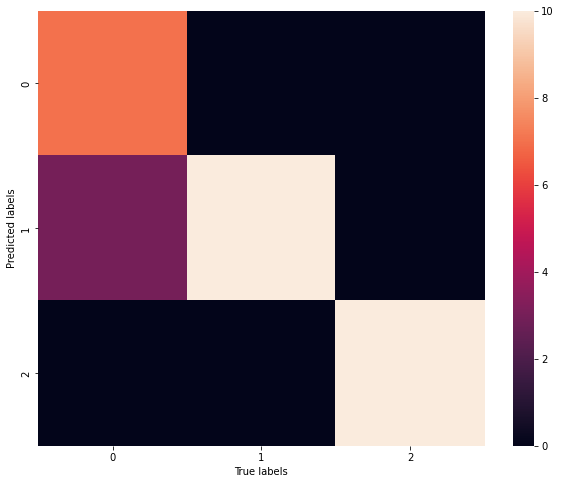

In [ ]:
predictions_2 = model_2.predict(X_test)

# Compute the confusion matrix
cm_2= confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))

# Compute the classification metrics
accuracy_2 = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1))
precision_2 = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
recall_2 = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
f1_2 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions_2, axis=-1), average='macro')
print('Accuracy:',accuracy_2.round(4))
print('Precision:',precision_2.round(4))
print('Recall:',recall_2.round(4))
print('F1:',f1_2.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_2.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Saving best model

In [ ]:
model_1.save('/gdrive/MyDrive/Colab Notebooks/NAML/Project/models/Handmade_3_classes')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab Notebooks/NAML/Project/models/Handmade_3_classes/assets


INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab Notebooks/NAML/Project/models/Handmade_3_classes/assets
